In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from midi.utils import midiread, midiwrite
import sys
sys.path.append("/Users/danshiebler/Documents")
import helper_functions as hf
# sys.path.append('/home/hanhong/Projects/python27/DeepLearningTutorials/code/')
# from utils import tile_raster_images
# import Image
from tensorflow.python.ops import control_flow_ops
from tqdm import tqdm
from matplotlib import pyplot as plt
import glob
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels,\
    mnist.test.images, mnist.test.labels
    
    
def get_songs(path='data/music_all/train/*.mid'):
    files = glob.glob(path)[:5]
    f = files[0]
    r=(21, 109)
    dt=0.3
    songs = [midiread(f, r, dt).piano_roll for f in tqdm(files)]
    return songs

songs = get_songs()


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting

/Users/danshiebler/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
100%|██████████| 5/5 [00:00<00:00, 21.87it/s]

 MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:

def build_rbm(x, W, bv_t, bh_t, k):
    size_bt = tf.shape(x)[0]

    # helper functions
    def sample(probs):
        return tf.to_float(tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1)))

    def sampleInt(probs):
        return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))

    # define graph/algorithm

    # CD-k
    # we use tf.while_loop to achieve the multiple (k - 1) gibbs sampling  
    # set up tf.while_loop()
    def rbmGibbs(xx, hh, count, k):
        xk = sampleInt(tf.sigmoid(tf.matmul(hh, tf.transpose(W)) + tf.tile(bv_t, [size_bt, 1])))
        hk = sampleInt(tf.sigmoid(tf.matmul(xk, W) + tf.tile(bh_t, [size_bt, 1])))
        return xk, hk, count+1, k

    def lessThanK(xk, hk, count, k):
        return count <= k

    ct = tf.constant(1) #counter
    h = sample(tf.sigmoid(tf.matmul(x, W) + tf.tile(bh_t, [size_bt, 1])))# sample h x1 h1 ..
    [xk1, hk1, _, _] = control_flow_ops.While(lessThanK, rbmGibbs, [x, h, ct, tf.constant(k)], 1, False)

    def free_energy(xx):
        #return -(v * bv_t).sum() - T.log(1 + T.exp(T.dot(v, W) + bh_t)).sum()
        A = -tf.reduce_sum(tf.sigmoid(tf.matmul(xx, W) + tf.tile(bh_t, [size_bt, 1])), 1)
        B = -tf.matmul(xx, tf.transpose(tf.cast(tf.tile(bv_t, [size_bt, 1]), tf.float32)))
        return tf.add(B, A)

    #Define loss and optimizer
    #the cost is based on the difference in free energy between v and v_sample
    e1 = free_energy(x)
    e2 = free_energy(xk1)
    cost = tf.reduce_mean(tf.sub(e1, e2))
    return xk1, cost


In [3]:
def build_rnnrbm( n_visible= 88, n_hidden= 150, n_hidden_recurrent= 100):

    # variables and place holder
    x  = tf.placeholder(tf.float32, [None, n_visible])
    a  = tf.placeholder(tf.float32)
    size_bt = tf.shape(x)[0]

#     bh = tf.Variable(tf.random_uniform([n_hidden], -0.005, 0.005))
#     bv = tf.Variable(tf.random_uniform([n_visible], -0.005, 0.005))

    W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01))
    bh = tf.Variable(tf.zeros([n_hidden], tf.float32))
    bv = tf.Variable(tf.zeros([n_visible], tf.float32))
    Wuh = tf.Variable(tf.random_normal([n_hidden_recurrent, n_hidden], 0.0001))
    Wuv = tf.Variable(tf.random_normal([n_hidden_recurrent, n_visible], 0.0001))
    Wvu = tf.Variable(tf.random_normal([n_visible, n_hidden_recurrent], 0.0001))
    Wuu = tf.Variable(tf.random_normal([n_hidden_recurrent, n_hidden_recurrent], 0.0001))
#     bu = tf.Variable(tf.random_normal([n_hidden_recurrent, 1], 0.0001))
    bu  = tf.Variable(tf.zeros([n_hidden_recurrent],  tf.float32))

    params = W, bh, bv, x, a, Wuh, Wuv, Wvu, Wuu, bu

    # If `v_t` is given, deterministic recurrence to compute the variable
    # biases bv_t, bh_t at each time step. If `v_t` is None, same recurrence
    # but with a separate Gibbs chain at each time step to sample (generate)
    # from the RNN-RBM. The resulting sample v_t is returned in order to be
    # passed down to the sequence history.
    
    def recurrence(xx, u_tm1, _0, _1, count, k):
        bv_t = tf.add(bv, tf.matmul(u_tm1, Wuv))
        bh_t = tf.add(bh, tf.matmul(u_tm1, Wuh))
        
        sl   = tf.slice(xx, [count, 0], [1, n_visible])
        u_t  = tf.tanh(bu + tf.matmul(sl, Wvu) + tf.matmul(u_tm1, Wuu))
        return [xx, u_t, bv_t, bh_t, count+1, k]

    def lessThanNumIter(_0, _1, _2, _3, count, num_iter):
        return count < num_iter

    ct   = tf.constant(1, tf.int32) #counter
    u0   = tf.zeros([1, n_hidden_recurrent], tf.float32)
    bh_t = tf.zeros([1, n_hidden],  tf.float32)#tf.random_uniform([1, n_hidden], -0.005, 0.005)
    bv_t = tf.zeros([1, n_visible],  tf.float32)#tf.random_uniform([1, n_visible], -0.005, 0.005)
    [x, u_t, bv_t, bh_t, _, _] = control_flow_ops.While(lessThanNumIter, recurrence, [x, u0, bv_t, bh_t, ct, size_bt])
    tf.scalar_summary('bv_t', bv_t)

    #Build this rbm based on the bias vectors that we already found 
    sample, cost = build_rbm(x, W, bv_t, bh_t, k=15)
    return x, sample, cost, params, bv_t, bh_t, size_bt

x, sample, cost, params, bv_t, bh_t, size_bt = build_rnnrbm()

W, bh, bv, x, a, Wuh, Wuv, Wvu, Wuu, bu = params
optimizer = tf.train.AdamOptimizer(learning_rate=a).minimize(cost)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)


In [5]:
#FILL THIS IN

num_epochs = 10
batch_size = 100
sess.close()
sess =  tf.InteractiveSession()
init = tf.initialize_all_variables()
sess.run(init)

before_W   = deepcopy(W.eval(session=sess))
before_Wuh = deepcopy(Wuh.eval(session=sess))
before_Wuv = deepcopy(Wuv.eval(session=sess))
before_Wvu = deepcopy(Wvu.eval(session=sess))
before_Wuu = deepcopy(Wuu.eval(session=sess))

before_bh  = deepcopy(bh.eval(session=sess))
before_bv  = deepcopy(bv.eval(session=sess))
before_bu  = deepcopy(bu.eval(session=sess))

# merged = tf.merge_all_summaries()
# writer = tf.train.SummaryWriter(sess.graph)

# loop with batch
for epoch in tqdm(range(num_epochs)):
    for song in songs[:5]:
        for i in range(1, len(song), batch_size):
            tr_x = song[i:i + batch_size]
#             alpha = min(0.05, 100/float(i))
            sess.run(optimizer, feed_dict={x: tr_x, a: 0.1})
#             sess.run([merged, optimizer], feed_dict={x: tr_x, a: 0.1})
#             print t1.eval(session=sess, feed_dict={x: tr_x, a: 0.1})
#             print t2.eval(session=sess, feed_dict={x: tr_x, a: 0.1})



100%|██████████| 9/9 [00:01<00:00,  7.55it/s]

100%|██████████| 9/9 [00:01<00:00,  8.44it/s]

100%|██████████| 6/6 [00:00<00:00,  8.74it/s]

100%|██████████| 9/9 [00:01<00:00,  7.54it/s]

100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

100%|██████████| 9/9 [00:01<00:00,  8.71it/s]

100%|██████████| 9/9 [00:01<00:00,  8.46it/s]

100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

100%|██████████| 9/9 [00:01<00:00,  8.01it/s]

100%|██████████| 6/6 [00:00<00:00,  8.13it/s]

100%|██████████| 9/9 [00:01<00:00,  8.27it/s]

100%|██████████| 9/9 [00:01<00:00,  6.81it/s]

100%|██████████| 10/10 [01:00<00:00,  6.08s/it]


/Users/danshiebler/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


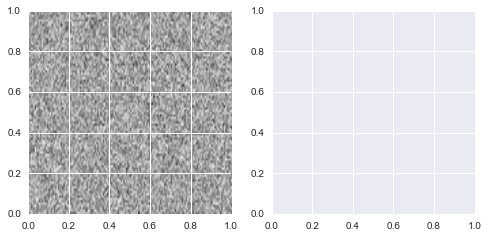

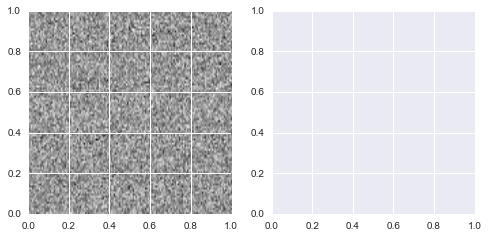

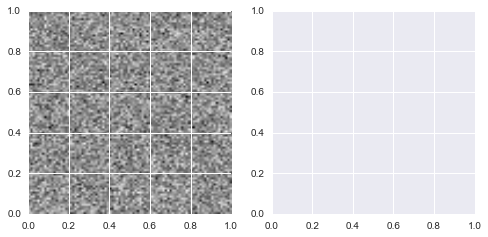

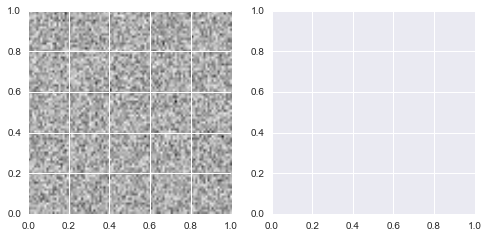

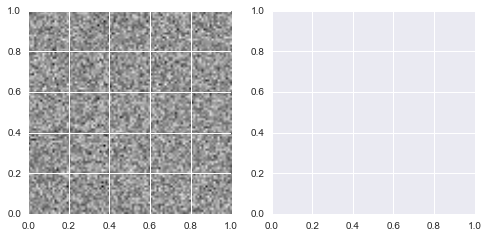

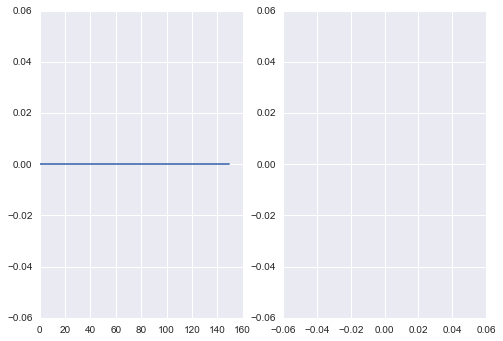

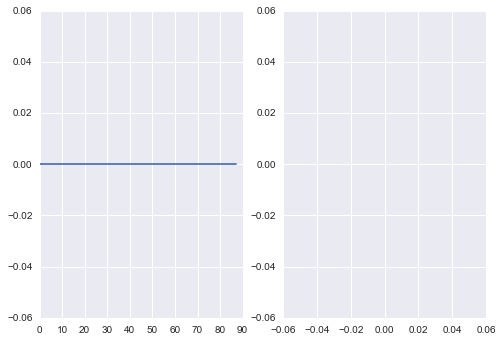

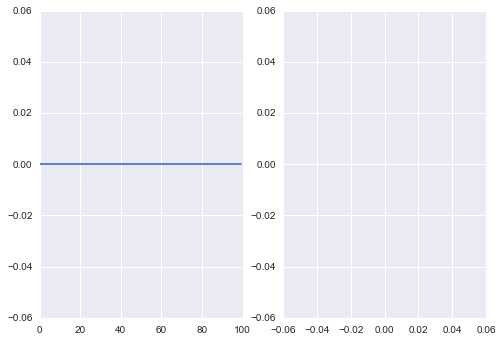

In [6]:
for wb, w in zip([before_W, before_Wuh, before_Wuv, before_Wvu, before_Wuu], [W, Wuh, Wuv, Wvu, Wuu]):
    plt.figure()
    plt.subplot(121)
    hf.plot2d(wb)
    plt.subplot(122)
    hf.plot2d(w.eval(session=sess))
    
for bb, b in zip([before_bh, before_bv, before_bu], [bh, bv, bu]):
    plt.figure()
    plt.subplot(121)
    plt.plot(bb)
    plt.subplot(122)
    plt.plot(b.eval(session=sess))

In [ ]:
sess.close()
